<div style="border-radius:12px;
            border: 2px solid #d35400;
            background-color:#fef5e6;
            font-size:115%;
            letter-spacing:0.6px;
            text-align: center;
            padding: 15px 0">
  
  <center><h1 style="padding: 20px 0; color:#d35400; font-weight: bold; font-family: 'Lucida Console', Monaco, monospace">
  🐾 Cats vs. Dogs 🐾</h1></center>
  
  <center><h3 style="padding-bottom: 20px; color:#d35400; font-weight: bold; font-style:italic; font-family: 'Lucida Console', Monaco, monospace">
  (Deep Learning - Data Augmentation - Transfer Learning)</h3></center>
  
</div>


In [1]:
import os, shutil
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


# Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import zipfile
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from keras.models import Sequential

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

# Define Functions

In [3]:
def plot_loss_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Import & organize Data

In [4]:
zip_df = zipfile.ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip", 'r')
zip_df.extractall("/kaggle/working/")
zip_df.close()

In [5]:
original_dataset_dir = '/kaggle/working/train'
base_dir = '/kaggle/working/catVsdog'
os.mkdir(base_dir)

In [6]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

# ------------------------------------
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# ------------------------------------
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)


In [7]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 0


In [8]:
fnames = ['cat.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(10000, 12500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# --------------------------------------------------------------
fnames = ['dog.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(10000, 12500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)


In [9]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 10000
total training dog images: 10000
total validation cat images: 2500
total validation dog images: 2500


# 1. CNN

In [10]:
model = Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=1e-4),
            metrics=['accuracy'])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# --------------------------------------
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=100,
        class_mode='binary')

# --------------------------------------
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [13]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,  # 20000 train images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=100  # 5000 validation images = batch_size * steps
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
200/200 [==============================] - 75s 335ms/step - loss: 0.6335 - accuracy: 0.6323 - val_loss: 0.5862 - val_accuracy: 0.6720
Epoch 2/20
200/200 [==============================] - 65s 327ms/step - loss: 0.5363 - accuracy: 0.7291 - val_loss: 0.5138 - val_accuracy: 0.7428
Epoch 3/20
200/200 [==============================] - 65s 327ms/step - loss: 0.4890 - accuracy: 0.7664 - val_loss: 0.4690 - val_accuracy: 0.7814
Epoch 4/20
200/200 [==============================] - 66s 330ms/step - loss: 0.4525 - accuracy: 0.7857 - val_loss: 0.4475 - val_accuracy: 0.7904
Epoch 5/20
200/200 [==============================] - 66s 332ms/step - loss: 0.4249 - accuracy: 0.8069 - val_loss: 0.4476 - val_accuracy: 0.7906
Epoch 6/20
200/200 [==============================] - 66s 331ms/step - loss: 0.3988 - accuracy: 0.8213 - val_loss: 0.4387 - val_accuracy: 0.7952
Epoch 7/20
200/200 [==============================] - 66s 329ms/step - loss: 0.3763 - accuracy: 0.8336 - val_loss: 0.4335 - val_ac

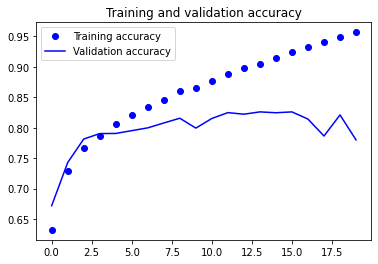

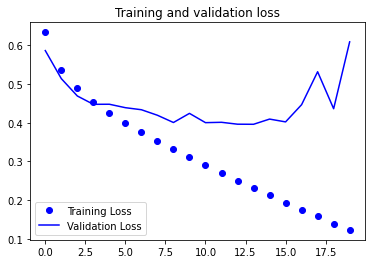

In [14]:
plot_loss_accuracy(history)

<div style="font-family: Cursive; font-size:16px; background-color:#ecfff5; padding: 25px 20px">
The plot above shows the pattern of overfitting.
</div>

# 2. Data augmentation and Dropout layer 

<div style="padding: 15px; font-family: 'Arial', sans-serif; 
            border: 3px dashed #3498db; 
            background-color: #eef7fe; 
            font-size: 16px; 
            border-radius: 12px;">
  
  <p style="margin-bottom: 15px;">To prevent overfitting, consider the following strategies:</p>
  <ul style="list-style-type: square; padding-left: 20px;">
      <li><strong>Dropout Layer</strong></li>
      <li><strong>Data Augmentation</strong></li>
  </ul>
  
</div>


<div style="padding: 10px; font-family: Cursive; border: solid 2px #015a2c;
            font-size:15.5px;padding: 25px 10px; border-radius:8px;">
<h3>What is Dropout? 🤔</h3>
<p>A single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during training. This is called dropout and offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds. 

</div>

<div style="padding: 10px; font-family: Cursive; border: solid 2px #015a2c;
            font-size:15.5px;padding: 25px 10px; border-radius:8px;">
<h3>What is image data augmentation? 🧐</h3>
<p>image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.<br> Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images. 
<p>Some image augmentation techniques include:</p>
<ul>
    <li>Image shifts</li>    
    <li>Image flips</li>
    <li>Image rotations</li>
    <li>Image zoom</li>
    <li>and ...</li>
</ul>

</div>

In [15]:
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                                rotation_range=50,
                                                width_shift_range=0.2,
                                                height_shift_range=0.2,
                                                shear_range=0.25,
                                                zoom_range=0.2,
                                                horizontal_flip=True,
                                                fill_mode='nearest')


train_generator = train_datagen_augmentation.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=100,
        class_mode='binary')

Found 20000 images belonging to 2 classes.


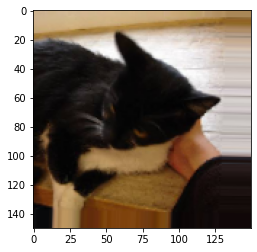

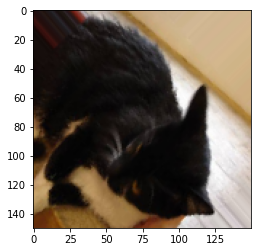

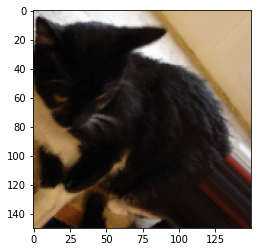

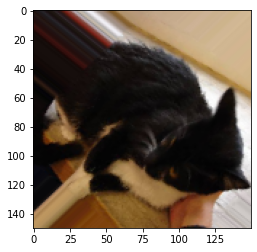

In [16]:
fname_cat = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

img_path = fname_cat[20]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen_augmentation.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

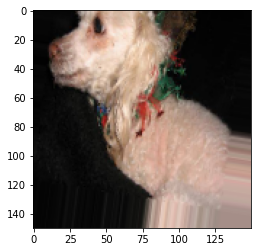

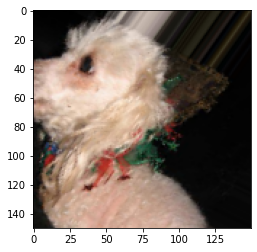

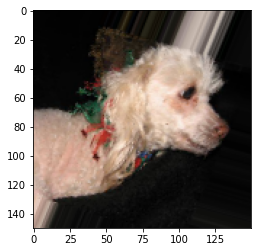

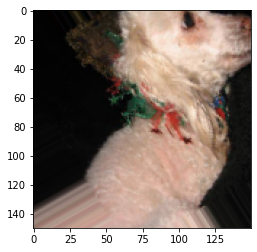

In [17]:
fname_dog = [os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)]

img_path = fname_dog[25]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen_augmentation.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [18]:
model_2 = Sequential()
model_2.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model_2.add(layers.MaxPooling2D(2, 2))
model_2.add(layers.Conv2D(64, (3,3), activation='relu'))
model_2.add(layers.MaxPooling2D(2,2))
model_2.add(layers.Conv2D(128, (3,3), activation='relu'))
model_2.add(layers.MaxPooling2D(2,2))

model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=1e-4),
            metrics=['accuracy'])


In [19]:
history = model_2.fit_generator(
      train_generator,
      steps_per_epoch=200,  # 20000 train images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=100  # 5000 validation images = batch_size * steps
)

Epoch 1/20
200/200 [==============================] - 161s 800ms/step - loss: 0.6732 - accuracy: 0.5788 - val_loss: 0.5933 - val_accuracy: 0.6874
Epoch 2/20
200/200 [==============================] - 158s 790ms/step - loss: 0.6205 - accuracy: 0.6484 - val_loss: 0.5609 - val_accuracy: 0.7150
Epoch 3/20
200/200 [==============================] - 158s 791ms/step - loss: 0.5933 - accuracy: 0.6761 - val_loss: 0.5385 - val_accuracy: 0.7324
Epoch 4/20
200/200 [==============================] - 162s 812ms/step - loss: 0.5755 - accuracy: 0.6919 - val_loss: 0.5109 - val_accuracy: 0.7602
Epoch 5/20
200/200 [==============================] - 159s 796ms/step - loss: 0.5638 - accuracy: 0.7047 - val_loss: 0.5101 - val_accuracy: 0.7572
Epoch 6/20
200/200 [==============================] - 159s 796ms/step - loss: 0.5484 - accuracy: 0.7156 - val_loss: 0.4853 - val_accuracy: 0.7704
Epoch 7/20
200/200 [==============================] - 160s 801ms/step - loss: 0.5430 - accuracy: 0.7210 - val_loss: 0.4756 -

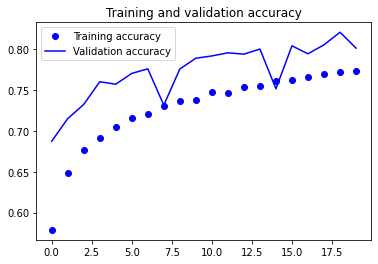

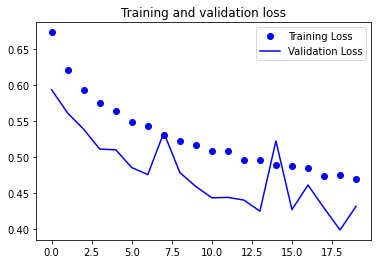

In [20]:
plot_loss_accuracy(history)

<div style="font-family: Cursive; font-size:16px; background-color:#ecfff5; padding: 25px 20px">
To increase accuracy, we can use transfer learning.
</div>

# 3. Transfer learning

<div style="padding: 10px; font-family: Cursive; border: solid 2px #015a2c;
            font-size:15.5px;padding: 25px 10px; border-radius:8px;">
<h3>What is Transfer Learning?</h3>
<p>Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task. <br> We can use 2 below strategies  for doing transfer learning:</p>
<ol>
    <li>Feature extraction</li>
    <p>Instead of using the model end-to-end as in the previous example, we can treat the pre-trained neural network as a feature extractor by discarding the last fully-connected output layer. This approach allows us to directly apply new dataset to solve an entirely different problem.</p>
    <li>Fine-tuning</li>
    <p>Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task. </p>
</ol>

</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #015a2c;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#015a2c; font-weight: bold; font-family: Cursive">
1. Feature extraction</h3></center>
</div>

In [21]:
base_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [22]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [23]:
model_3 = Sequential()
model_3.add(base_model)
model_3.add(layers.Flatten())
model_3.add(layers.Dense(512, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=1e-4),
            metrics=['accuracy'])

In [24]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 18,910,017
Non-trainable params: 0
_________________________________________________________________


In [25]:
print('This is the number of trainable weights '
      'before freezing the base model:', len(model_3.trainable_weights))

This is the number of trainable weights before freezing the base model: 30


In [26]:
base_model.trainable = False

In [27]:
print('This is the number of trainable weights '
      'after freezing the base model:', len(model.trainable_weights))

This is the number of trainable weights after freezing the base model: 10


In [28]:
history = model_3.fit_generator(
      train_generator,
      steps_per_epoch=200,  # 20000 train images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=100  # 5000 validation images = batch_size * steps
)

Epoch 1/20
200/200 [==============================] - 172s 821ms/step - loss: 0.6287 - accuracy: 0.6566 - val_loss: 0.3543 - val_accuracy: 0.8510
Epoch 2/20
200/200 [==============================] - 161s 802ms/step - loss: 0.3691 - accuracy: 0.8359 - val_loss: 0.1975 - val_accuracy: 0.9160
Epoch 3/20
200/200 [==============================] - 160s 797ms/step - loss: 0.2673 - accuracy: 0.8839 - val_loss: 0.1310 - val_accuracy: 0.9476
Epoch 4/20
200/200 [==============================] - 160s 797ms/step - loss: 0.2057 - accuracy: 0.9144 - val_loss: 0.1323 - val_accuracy: 0.9586
Epoch 5/20
200/200 [==============================] - 158s 787ms/step - loss: 0.1724 - accuracy: 0.9297 - val_loss: 0.1140 - val_accuracy: 0.9606
Epoch 6/20
200/200 [==============================] - 158s 787ms/step - loss: 0.1576 - accuracy: 0.9376 - val_loss: 0.0975 - val_accuracy: 0.9646
Epoch 7/20
200/200 [==============================] - 157s 784ms/step - loss: 0.1565 - accuracy: 0.9371 - val_loss: 0.1081 -

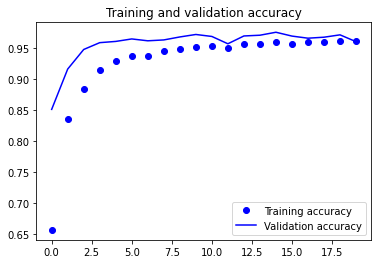

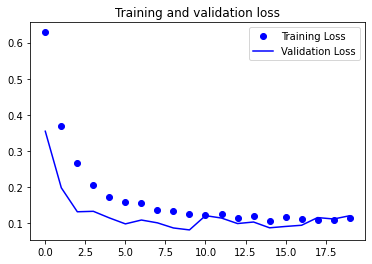

In [29]:
plot_loss_accuracy(history)

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #015a2c;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#015a2c; font-weight: bold; font-family: Cursive">
2. Fine-Tuning</h3></center>
</div>

In [30]:
for l in base_model.layers:
    print("layer name is : ",l.name," ** trainable is ", l.trainable)

layer name is :  input_1  ** trainable is  False
layer name is :  block1_conv1  ** trainable is  False
layer name is :  block1_conv2  ** trainable is  False
layer name is :  block1_pool  ** trainable is  False
layer name is :  block2_conv1  ** trainable is  False
layer name is :  block2_conv2  ** trainable is  False
layer name is :  block2_pool  ** trainable is  False
layer name is :  block3_conv1  ** trainable is  False
layer name is :  block3_conv2  ** trainable is  False
layer name is :  block3_conv3  ** trainable is  False
layer name is :  block3_pool  ** trainable is  False
layer name is :  block4_conv1  ** trainable is  False
layer name is :  block4_conv2  ** trainable is  False
layer name is :  block4_conv3  ** trainable is  False
layer name is :  block4_pool  ** trainable is  False
layer name is :  block5_conv1  ** trainable is  False
layer name is :  block5_conv2  ** trainable is  False
layer name is :  block5_conv3  ** trainable is  False
layer name is :  block5_pool  ** trai

In [31]:
base_model.trainable = True
tmp = False
for l in base_model.layers:
    if l.name == "block5_conv1":
        tmp = True
    if tmp:
        l.trainable = True
    else:
        l.trainable = False

In [32]:
model_3.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=1e-4),
            metrics=['accuracy'])

In [33]:
early_stopping = EarlyStopping(patience=3, monitor='val_loss')

In [34]:
history = model_3.fit_generator(
      train_generator,
      steps_per_epoch=200,  # 20000 train images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=100,  # 5000 validdation images = batch_size * steps
      callbacks=[early_stopping])

Epoch 1/20
200/200 [==============================] - 159s 791ms/step - loss: 0.0702 - accuracy: 0.9747 - val_loss: 0.2292 - val_accuracy: 0.9704
Epoch 2/20
200/200 [==============================] - 155s 775ms/step - loss: 0.0694 - accuracy: 0.9744 - val_loss: 0.1417 - val_accuracy: 0.9710
Epoch 3/20
200/200 [==============================] - 155s 775ms/step - loss: 0.0663 - accuracy: 0.9760 - val_loss: 0.2509 - val_accuracy: 0.9718
Epoch 4/20
200/200 [==============================] - 155s 775ms/step - loss: 0.0634 - accuracy: 0.9770 - val_loss: 0.1899 - val_accuracy: 0.9734
Epoch 5/20
200/200 [==============================] - 155s 773ms/step - loss: 0.0640 - accuracy: 0.9757 - val_loss: 0.2718 - val_accuracy: 0.9712


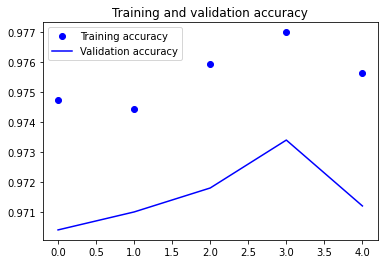

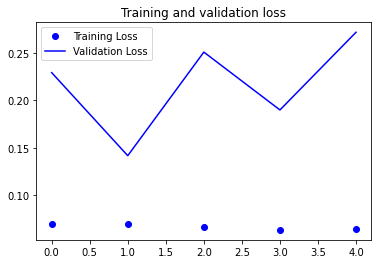

In [35]:
plot_loss_accuracy(history)